In [1]:
import json
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (25, 5)

In [4]:
import attrs
import typing as t




In [5]:

def parse(data_dict: dict):
    parsed_dict = {
        "id": data_dict["id"].split(" ")[1],
        "url": data_dict["url"],
        "tytul": data_dict["title"],
        "opis": re.sub(r'\n+', '.', data_dict["description"]),
        "cena": int(data_dict["price"].split("zł")[0].replace(" ", "").split(",")[0]),
        "prywatne": data_dict["parameters"].pop(0) == "Prywatne" if len("parameters") else None
    }
    
    attributes_dict = {attribute.split(":")[0].strip(): attribute.split(":")[1].strip() for attribute in data_dict["parameters"]}
    
    print(attributes_dict)
    
    parsed_dict = {
        **parsed_dict,
        "model": attributes_dict.get("Model", None),
        "rok_produkcji": int(attributes_dict.get("Rok produkcji")) if "Rok produkcji" in attributes_dict else None,
        "paliwo": attributes_dict.get("Paliwo", None),
        "przebieg": int(attributes_dict["Przebieg"].split("km")[0].replace(" ", "")) if "Przebieg" in attributes_dict else None,
        "pojemnosc": int(attributes_dict["Poj. silnika"].split("cm")[0].replace(" ", "")) if "Poj. silnika" in attributes_dict else None,
        "skrzynia_biegow": attributes_dict.get("Skrzynia biegów", None),
        "kraj_pochodzenia": attributes_dict.get("Kraj pochodzenia", "Polska"),
        "moc": int(attributes_dict["Moc silnika"].split(" ")[0]) if "Moc silnika" in attributes_dict else None,
    }

    return CarListing(**parsed_dict)

In [6]:
res = []

for entry in data:
    res.append(parse(entry))



{'Model': 'Seria 5', 'Rok produkcji': '2003', 'Paliwo': 'LPG', 'Typ nadwozia': 'Sedan', 'Przebieg': '340 000 km', 'Kolor': 'Srebrny', 'Stan techniczny': 'Nieuszkodzony', 'Skrzynia biegów': 'Automatyczna'}
{'Model': 'Seria 7', 'Rok produkcji': '2005', 'Paliwo': 'Diesel', 'Typ nadwozia': 'Sedan', 'Przebieg': '282 000 km', 'Kolor': 'Czarny', 'Poj. silnika': '2 998 cm³', 'Stan techniczny': 'Nieuszkodzony', 'Skrzynia biegów': 'Automatyczna', 'Kraj pochodzenia': 'Niemcy', 'Moc silnika': '231 KM', 'Napęd': 'Na tylne koła', 'Kierownica': 'po lewej'}
{'Model': 'Seria 3', 'Rok produkcji': '1997', 'Paliwo': 'Benzyna', 'Typ nadwozia': 'Sedan', 'Przebieg': '300 000 km', 'Kolor': 'Czarny', 'Stan techniczny': 'Nieuszkodzony', 'Skrzynia biegów': 'Manualna', 'Moc silnika': '192 KM'}
{'Model': 'Seria 3', 'Rok produkcji': '1992', 'Paliwo': 'Benzyna', 'Typ nadwozia': 'Sedan', 'Przebieg': '260 000 km', 'Kolor': 'Srebrny', 'Poj. silnika': '1 800 cm³', 'Stan techniczny': 'Nieuszkodzony', 'Skrzynia biegów': '

In [7]:
df = pd.DataFrame([attrs.asdict(car) for car in res])

['Seria 5',
 'Seria 7',
 'Seria 3',
 'X5',
 '308',
 'Seria 4',
 'X3',
 'Aerostar',
 'X5 M',
 'X6',
 'Patrol',
 'Seria 1',
 'Pozostałe BMW',
 'Caddy',
 'M5',
 'B3',
 'Seria 6',
 'S Klasa',
 'Touareg',
 'LS',
 'i5',
 'City',
 'Vectra',
 'A4 Avant',
 '3008',
 'Coupe',
 'Countryman',
 'XC 90',
 'Kadett',
 'Passat',
 'M2',
 'E Klasa',
 'A4 Limousine',
 'S80',
 'Explorer',
 'Vitara',
 'Escort',
 'Caro',
 'iX1',
 'M3',
 'Corolla',
 'Prelude',
 'Seria 2',
 'H-1',
 None,
 'Bravo',
 'Corsa',
 'Zafira',
 '207',
 'Trans Sport',
 'A6 Allroad',
 'Z3',
 'A8',
 'Q5',
 'Z4',
 'Antara',
 'X1',
 'Astra']

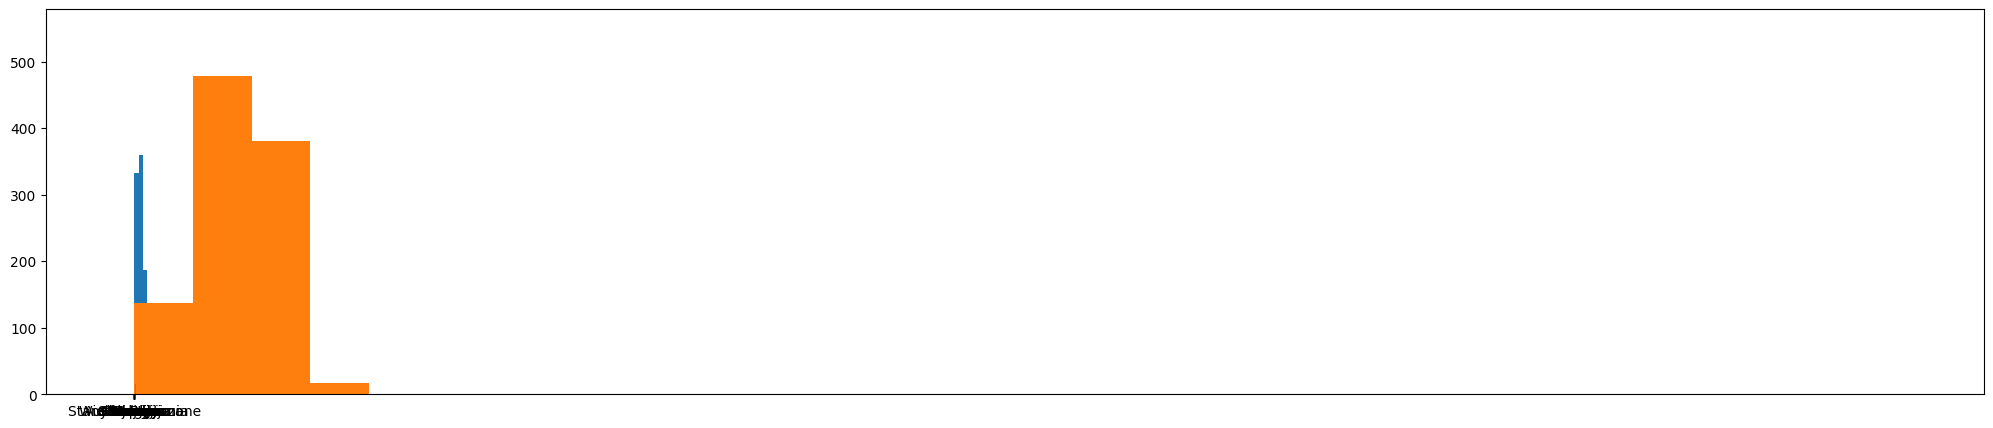

In [143]:
plt.hist(df["cena"], bins=30)
plt.hist(df["przebieg"], bins=30)
plt.hist(df["moc"], bins=30)
plt.hist(df["rok_produkcji"], bins=25)
plt.hist(df["pojemnosc"], bins=25)
plt.hist(df["skrzynia_biegow"], bins=25)
plt.hist(df["kraj_pochodzenia"], bins=25)
df["model"].unique().tolist()

In [144]:
df["text"] = df["tytul"] + ". " + df["opis"]
df = df[df["cena"] < 100_000] # drop drogich
df = df[(df['rok_produkcji'] > 1980) & (df['rok_produkcji'] < 2010)] 
df = df[(df["przebieg"] < 800_000) & (df["przebieg"] > 10_000)]
df["wiek"] = 2025 - df["rok_produkcji"]

len(df)


882

# SCALE VALUES & ENCODING

In [145]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = MinMaxScaler()

df['cena_norm'] = scaler.fit_transform(df[['cena']])
df['przebieg_norm'] = scaler.fit_transform(df[['przebieg']])
df["wiek_norm"] = scaler.fit_transform(df[['wiek']])
df["moc_norm"] = scaler.fit_transform(df[['moc']])
df["pojemnosc_norm"] = scaler.fit_transform(df[['pojemnosc']])

kraj_mapping = {"Polska": "Polska", "Niemcy": "Niemcy"}
df["kraj_norm"] = df["kraj_pochodzenia"].map(kraj_mapping).fillna("Inny")


In [147]:
paliwo = pd.get_dummies(df["paliwo"], prefix="paliwo").astype(int)
df = pd.concat([df, paliwo], axis=1)

kraj = pd.get_dummies(df["kraj_norm"], prefix="kraj").astype(int)
df = pd.concat([df, kraj], axis=1)

df["prywatne_norm"] = df["prywatne"].astype(int)

df["skrzynia_norm"] = df["skrzynia_biegow"].map({"Automatyczna": 1, "Manualna": 0})

In [148]:
df.dtypes

id                   object
url                  object
tytul                object
opis                 object
cena                  int64
prywatne               bool
model                object
rok_produkcji         int64
paliwo               object
przebieg              int64
pojemnosc           float64
skrzynia_biegow      object
kraj_pochodzenia     object
moc                 float64
text                 object
wiek                  int64
cena_norm           float64
przebieg_norm       float64
wiek_norm           float64
moc_norm            float64
pojemnosc_norm      float64
kraj_norm            object
paliwo_Benzyna        int64
paliwo_Diesel         int64
paliwo_LPG            int64
kraj_Inny             int64
kraj_Niemcy           int64
kraj_Polska           int64
prywatne_norm         int64
skrzynia_norm         int64
dtype: object

In [149]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

embeddings = model.encode(df['text'].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/28 [00:00<?, ?it/s]

In [150]:
cleaned_df = df.drop(columns=["id", "url", 'tytul', "text", "opis", "prywatne", "model", "rok_produkcji",
                              "paliwo", "przebieg", "pojemnosc", "skrzynia_biegow", "kraj_pochodzenia", "moc",
                              "cena", "wiek", "cena_norm", "kraj_norm"])

In [154]:
cleaned_df.dtypes

przebieg_norm     float64
wiek_norm         float64
moc_norm          float64
pojemnosc_norm    float64
paliwo_Benzyna      int64
paliwo_Diesel       int64
paliwo_LPG          int64
kraj_Inny           int64
kraj_Niemcy         int64
kraj_Polska         int64
prywatne_norm       int64
skrzynia_norm       int64
dtype: object

In [161]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

Epoch 1/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0303 - mae: 0.1332 - val_loss: 0.0296 - val_mae: 0.1371
Epoch 2/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0280 - mae: 0.1278 - val_loss: 0.0297 - val_mae: 0.1380
Epoch 3/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0281 - mae: 0.1290 - val_loss: 0.0304 - val_mae: 0.1303
Epoch 4/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0281 - mae: 0.1279 - val_loss: 0.0334 - val_mae: 0.1291
Epoch 5/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0284 - mae: 0.1275 - val_loss: 0.0303 - val_mae: 0.1305
Epoch 6/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0276 - mae: 0.1267 - val_loss: 0.0296 - val_mae: 0.1333
Epoch 7/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0274 - mae: 0.1267 - val_loss: 0.0297 - val_mae: 0.1330
Epoch 8/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0275 - mae: 0.1270 - val_loss: 0.0306 - val_mae: 0.1300
Epoch 9/1000
177/177 ━━━━━━━━━━━━━━━━━━━

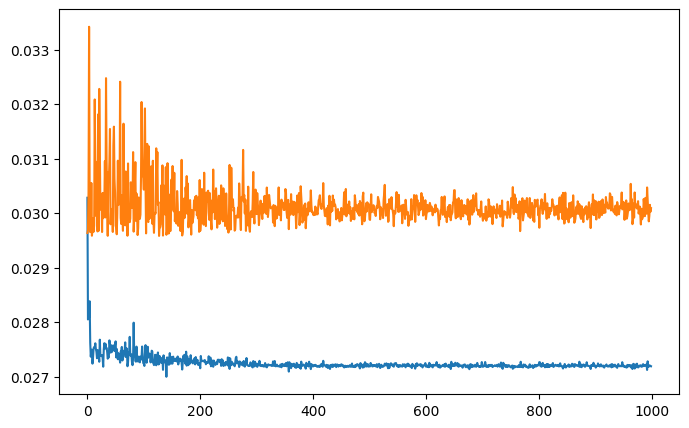

In [160]:
x = np.hstack([embeddings, cleaned_df.to_numpy()])
y = df["cena_norm"].to_numpy()


# Split data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model = models.Sequential([
    layers.Input(shape=(x_train.shape[1],)),   # embedding size (384 for all-MiniLM-L6-v2)
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # regression output
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(x_train, y_train, 
                    validation_data=(x_test, y_test),
                    epochs=1000, batch_size=4, verbose=1)

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

Epoch 1/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0305 - mae: 0.1345 - val_loss: 0.0299 - val_mae: 0.1316
Epoch 2/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0283 - mae: 0.1277 - val_loss: 0.0308 - val_mae: 0.1297
Epoch 3/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0285 - mae: 0.1281 - val_loss: 0.0296 - val_mae: 0.1349
Epoch 4/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0278 - mae: 0.1257 - val_loss: 0.0296 - val_mae: 0.1347
Epoch 5/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0277 - mae: 0.1268 - val_loss: 0.0301 - val_mae: 0.1310
Epoch 6/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0276 - mae: 0.1285 - val_loss: 0.0304 - val_mae: 0.1303
Epoch 7/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0277 - mae: 0.1269 - val_loss: 0.0312 - val_mae: 0.1293
Epoch 8/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0272 - mae: 0.1254 - val_loss: 0.0302 - val_mae: 0.1306
Epoch 9/1000
177/177 ━━━━━━━━━━━━━━━━━━━

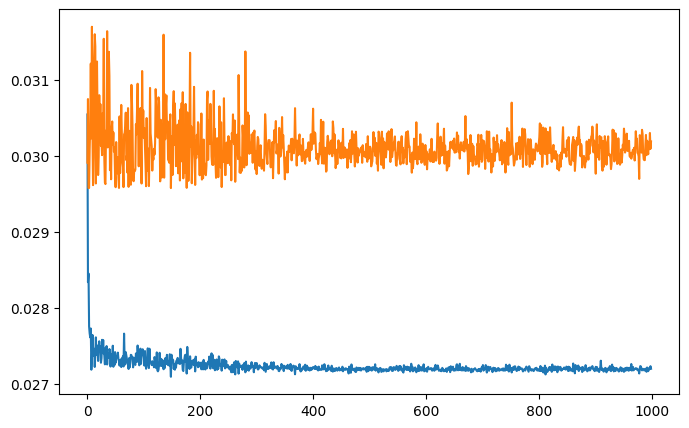

In [162]:
x = cleaned_df.to_numpy()
y = df["cena_norm"].to_numpy()


# Split data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model = models.Sequential([
    layers.Input(shape=(x_train.shape[1],)),   # embedding size (384 for all-MiniLM-L6-v2)
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # regression output
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(x_train, y_train, 
                    validation_data=(x_test, y_test),
                    epochs=1000, batch_size=4, verbose=1)

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

ValueError: Your currently installed version of Keras is Keras 3, but this is not yet supported in Transformers. Please install the backwards-compatible tf-keras package with `pip install tf-keras`.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, df['cena'], test_size=0.2, random_state=42)

# 4️⃣ Normalize targets (optional but helps training)

y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

# 5️⃣ Define a neural network in TensorFlow
model = models.Sequential([
    layers.Input(shape=(embeddings.shape[1],)),   # embedding size (384 for all-MiniLM-L6-v2)
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # regression output
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 6️⃣ Train
history = model.fit(X_train, y_train_scaled, 
                    validation_data=(X_test, y_test_scaled),
                    epochs=100, batch_size=4, verbose=1)

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

Epoch 1/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9684 - mae: 0.7560 - val_loss: 0.9250 - val_mae: 0.6917
Epoch 2/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8730 - mae: 0.7093 - val_loss: 0.8774 - val_mae: 0.6563
Epoch 3/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7044 - mae: 0.6255 - val_loss: 0.8577 - val_mae: 0.7080
Epoch 4/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6619 - mae: 0.6134 - val_loss: 0.7705 - val_mae: 0.6349
Epoch 5/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5763 - mae: 0.5720 - val_loss: 0.7906 - val_mae: 0.6136
Epoch 6/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5548 - mae: 0.5548 - val_loss: 0.7778 - val_mae: 0.6216
Epoch 7/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5208 - mae: 0.5334 - val_loss: 0.7413 - val_mae: 0.6129
Epoch 8/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4813 - mae: 0.5148 - val_loss: 0.7758 - val_mae: 0.6586
Epoch 9/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/

[7201.974609375, 11301.974609375, 13202.974609375, 5598.025390625, 20798.025390625, 12301.974609375, 13298.025390625, 3301.974609375, 8901.974609375, 2701.974609375, 7598.025390625, 8202.974609375, 2698.025390625, 11798.025390625, 11701.974609375, 17201.974609375, 9701.974609375, 7301.974609375, 5698.025390625, 2201.974609375, 9301.974609375, 13101.974609375, 10301.974609375, 2701.974609375, 2298.025390625, 12701.974609375, 11701.974609375, 301.974609375, 3501.974609375, 2701.974609375, 9201.974609375, 701.974609375, 12301.974609375, 3301.974609375, 201.974609375, 10401.974609375, 2597.025390625, 11797.025390625, 8201.974609375, 1798.025390625, 9901.974609375, 5301.974609375, 14711.974609375, 6797.025390625, 6298.025390625, 15398.025390625, 16901.974609375, 6798.025390625, 12701.974609375, 2701.974609375, 14701.974609375, 13298.025390625, 8301.974609375, 10701.974609375, 9301.974609375, 10798.025390625, 23798.025390625, 8301.974609375, 12701.974609375, 8698.025390625, 7201.974609375, 2